# NFL Fantasy Models

1. Config
2. Read in Feature Store
3. Baseline Model
4. Feature Selection
5. Hyperparameter Tuning
6. Train Model
7. Evaluate Model
8. Compare Baseline to Optimized Model

## 1. Config

In [112]:
import pandas as pd
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.width', 1000)
import requests


import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import optuna
import xgboost as xgb
from decimal import Decimal
from typing import Any
import datetime
import os
import json
import pyarrow as pa
from typing import List

#####################################################
root_path = '../data/feature_store'

fs_type_path = 'player/season'
fs_file_name = 'fs.parquet'

year = 2023
position = 'QB'
target = 'fantasy_points'
n_features = 25
n_trials = 40
#####################################################
META_COLS = [
    'player_id',
    'season', 
    target,
    'display_name', 
    'position_group'
]

class ExperimentData:
    def __init__(self, experiment_class, year, position, target):
        """
        Crud operations for collecting information for an experiment

        1. Define what feature store the experiment used
        2. Define what experiment class this is part of
        3. Define year the experiment is ran for
        4. Define the target variable used
        5. Define the position the model was built for
        6. Define initial baseline model performance
        7. Define features selected from feature selection process
        8. Define hyperparameters selected from hpo process
        9. Define tuned model performance
        10. Define inference path
        """
        self.experiment_class = experiment_class
        self.year = year
        self.position = position
        self.target = target

        self.feature_store = None
        self.initial_baseline_performance = None
        self.selected_features = None
        self.hyperparameters = None
        self.tuned_model_performance = None
        self.experiment_path = f"../data/experiments/{self.experiment_class}/{self.year}/{self.position}/{self.target}.json"
        self.inference_path = f"../data/experiments/{self.experiment_class}/{self.year}/{self.position}/{self.target}.parquet"

        self._ensure_directory_exists(os.path.dirname(self.experiment_path))

    def _ensure_directory_exists(self, path):
        if not os.path.exists(path):
            os.makedirs(path)

    def save_experiment(self):
        experiment_data = {
            "feature_store": self.feature_store,
            "initial_baseline_performance": self.initial_baseline_performance,
            "selected_features": self.selected_features,
            "hyperparameters": self.hyperparameters,
            "tuned_model_performance": self.tuned_model_performance,
            "inference_path": self.inference_path
        }

        with open(self.experiment_path, 'w') as f:
            json.dump(experiment_data, f, indent=4)

    def load_experiment(self):
        if os.path.exists(self.experiment_path):
            with open(self.experiment_path, 'r') as f:
                experiment_data = json.load(f)
            self.feature_store = experiment_data.get("feature_store")
            self.initial_baseline_performance = experiment_data.get("initial_baseline_performance")
            self.selected_features = experiment_data.get("selected_features")
            self.hyperparameters = experiment_data.get("hyperparameters")
            self.tuned_model_performance = experiment_data.get("tuned_model_performance")
            self.inference_path = experiment_data.get("inference_path")
            return self.__dict__
        else:
            print(f"No experiment data found at {self.experiment_path}")
            return None

    def set_feature_store(self, feature_store):
        self.feature_store = feature_store

    def set_initial_baseline_performance(self, performance):
        self.initial_baseline_performance = performance

    def set_selected_features(self, features):
        self.selected_features = features

    def set_hyperparameters(self, hyperparameters):
        self.hyperparameters = hyperparameters

    def set_tuned_model_performance(self, performance):
        self.tuned_model_performance = performance


def get_dataframe(path: str, columns: List = None):
    """
    Read a DataFrame from a parquet file.

    Args:
        path (str): Path to the parquet file.
        columns (List): List of columns to select (default is None).

    Returns:
        pd.DataFrame: Read DataFrame.
    """
    try:
        return pd.read_parquet(path, engine='pyarrow', dtype_backend='numpy_nullable', columns=columns)
    except Exception as e:
        print(e)
        return pd.DataFrame()

def train_test_split(feature_store_df, position, year, target, holdout=False):
    train_years = list(range(2010, year - 1))
    holdout_year = year - 1
    test_year = year
    meta_cols = [
        'player_id',
        'season', 
        'fantasy_points', 
        'display_name', 
        'college_name', 
        'birth_date', 
        'entry_year', 
        'position',
        'position_group'
    ]

    # Filter for the specific position
    pos_df = feature_store_df[feature_store_df['position_group'] == position].copy()

    if position == 'QB':
        filt = (pos_df['total_last_year_completions'] >= 0) | (pos_df['total_2_years_ago_completions'] >= 0) | (pos_df['years_of_experience'] == 0)
        print("Records Dropped during train-test split: ",pos_df.shape[0] - sum(filt))
        pos_df = pos_df[filt].copy()

    # Split the data
    train_df = pos_df[pos_df['season'].isin(train_years)].copy()
    holdout_df = pos_df[pos_df['season'] == holdout_year].copy()
    test_df = pos_df[pos_df['season'] == test_year].copy()

    cols_to_drop = list(set(meta_cols + list(train_df.select_dtypes(exclude=[np.number]).columns)))
    if target == 'fantasy_points':
        cols_to_drop.extend([col for col in train_df.columns if 'ppr' in col] + ['position_rank', 'avg_last_year_fantasy_points'])
    elif target == 'fantasy_points_ppr':
        cols_to_drop.extend([col for col in train_df.columns if 'fantasy_points' in col and 'ppr' not in col]  + ['ppr_position_rank', 'avg_last_year_ppr_fantasy_points'])
    else:
        Exception('Invalid target variable: Accepted values are "fantasy_points" or "fantasy_points_ppr"')
    #print(cols_to_drop)
    # Define features and target variable
    X_train = train_df.drop(columns=cols_to_drop)
    y_train = train_df[target]

    X_test = test_df.drop(columns=cols_to_drop)
    y_test = test_df[target]

    if holdout:
        X_holdout = holdout_df.drop(columns=cols_to_drop)
        y_holdout = holdout_df[target]
    else:
        X_holdout = None
        y_holdout = None
        X_train = pd.concat([X_train, holdout_df.drop(columns=cols_to_drop)])
        y_train = pd.concat([y_train, holdout_df[target]])

    return X_train, y_train, X_holdout, y_holdout, X_test, y_test, test_df[META_COLS]

## 2. Read in Feature Store

In [114]:
experiment_obj = ExperimentData(experiment_class="FantasyFootball", year=year, position=position, target=target)
experiment = experiment_obj.load_experiment()

path = f"{root_path}/{fs_type_path}/{fs_file_name}"
if experiment is None:
    experiment_obj.set_feature_store(path)
fs_df = get_dataframe(path)

No experiment data found at ../data/experiments/FantasyFootball/2023/QB/fantasy_points.json


## 3. Baseline Model

In [115]:
def train_baseline_model(feature_store_df, position, year, target):
    X_train, y_train, X_holdout, y_holdout, X_test, y_test, meta_test = train_test_split(feature_store_df, position, year, target, holdout=True)

    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
    }
    model = xgb.XGBRegressor(**param, early_stopping_rounds=50, random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_holdout, y_holdout)], verbose=False)
    preds = model.predict(X_test)
    meta_test['predictions'] = preds
    mae = mean_absolute_error(y_test, preds)
    return mae, model, meta_test
if experiment is None or experiment['initial_baseline_performance'] is None:
    baseline_mae, baseline_model, baseline_meta_test = train_baseline_model(fs_df, position, year, target)
    experiment_obj.set_initial_baseline_performance(baseline_mae)
print(f'Mean Absolute Error for {year} {position}s on test set: {baseline_mae}')

Records Dropped during train-test split:  0
Mean Absolute Error for 2023 QBs on test set: 78.92957902927787


In [116]:
baseline_meta_test.sort_values(by='predictions', ascending=False)

,player_id,season,fantasy_points,display_name,position_group,predictions
10047,00-0036355,2023,233.160004,Justin Herbert,QB,311.712524
10077,00-0036389,2023,356.820007,Jalen Hurts,QB,287.173370
10118,00-0036442,2023,147.160004,Joe Burrow,QB,281.559204
9058,00-0033873,2023,280.220001,Patrick Mahomes,QB,267.958008
5575,00-0026498,2023,243.100006,Matthew Stafford,QB,264.251099
7031,00-0029604,2023,149.740005,Kirk Cousins,QB,257.922180
9498,00-0034796,2023,331.220001,Lamar Jackson,QB,256.477539
9673,00-0035228,2023,146.360001,Kyler Murray,QB,248.307114
9569,00-0034857,2023,394.640015,Josh Allen,QB,242.149734
8699,00-0033077,2023,342.839996,Dak Prescott,QB,222.801483


## 4. Feature Selection

Records Dropped during train-test split:  0


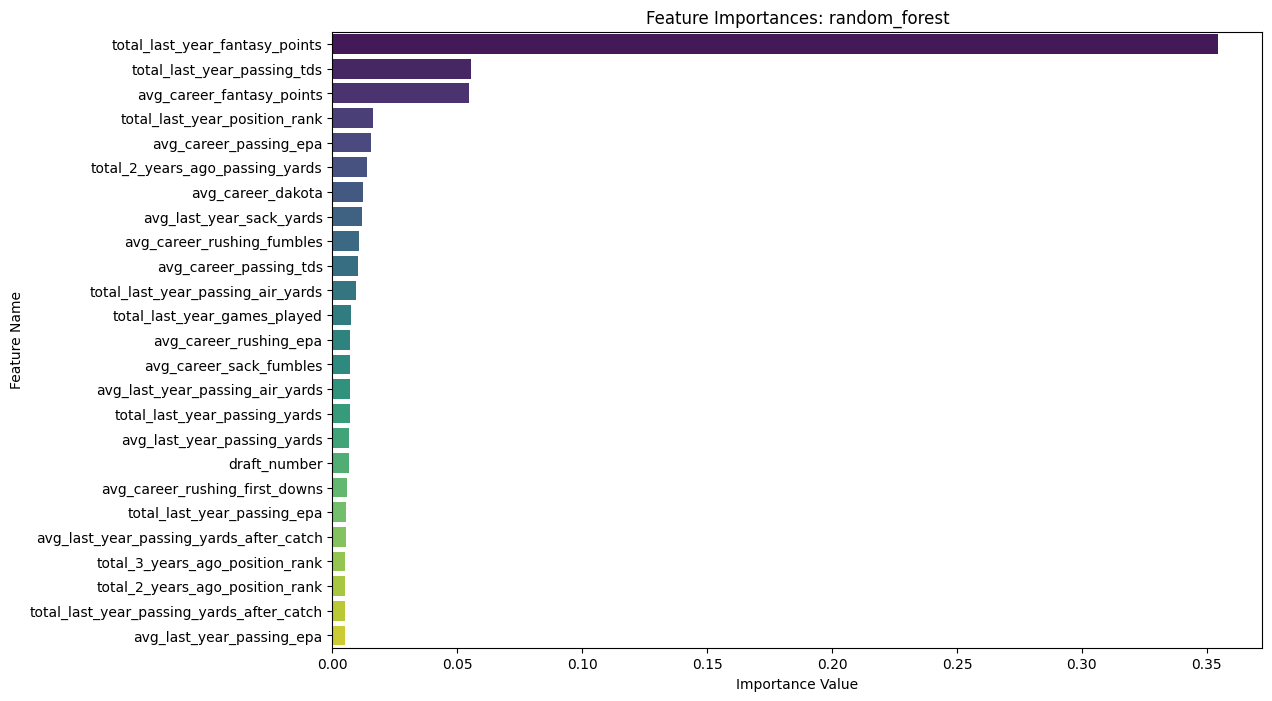

In [117]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
import optuna
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


class FeatureSelection:
    """
    return a list of features
    """
    def __init__(self, X, y, n_features=25, visualize=False):
        self.X = X
        self.y = y
        self.n_features = n_features
        self.features = {}
        self.selected_features = None
        self.visualize = visualize

    def univariate_feature_selection(self):
        """
        When to Use:
        - Initial Screening: When you have a large number of features and you want to perform an initial screening to identify the most relevant features.
        - Simple and Fast: Useful for quick, simple problems where you need to identify strong individual relationships between each feature and the target variable.

        Advantages:
        - Simplicity: Easy to understand and implement.
        - Speed: Computationally efficient, especially for large datasets.

        Disadvantages:
        - Ignores Feature Interactions: Only considers each feature independently, without considering interactions between features.
        """
        if not self.features:
            self.features = {}
        self.features['univariate'] = self._univariate_feature_selection()
        if self.visualize:
            self.visualize_features('univariate')
        return self.features['univariate']

    def rfe_feature_selection(self):
        """
        When to Use:
        - Feature Interactions: When you suspect that interactions between features are important and you want a method that takes these into account.
        - Model-Based Selection: When you want to incorporate model performance into the feature selection process.

        Advantages:
        - Considers Interactions: Takes into account the contribution of each feature in the context of other features.
        - Model-Based: Uses the performance of a machine learning model to guide feature selection.

        Disadvantages:
        - Computationally Intensive: Can be slow, especially for large datasets and complex models.
        - Model-Specific: The selected features may be biased towards the specific model used in the RFE process.
        """

        if not self.features:
            self.features = {}
        self.features['rfe'] = self.rfe_feature_selection()
        if self.visualize:
            self.visualize_features('rfe')

    def random_forest_feature_importance(self):
        """
        When to Use:
        - Non-Linear Relationships: When you want to capture non-linear relationships between features and the target variable.
        - Model-Based Selection: When you prefer an ensemble method that can handle a large number of features and provide importance scores.

        Advantages:
        - Handles Non-Linearities: Effective for capturing complex relationships.
        - Robust to Overfitting: Random forests are generally robust to overfitting, especially with a large number of features.

        Disadvantages:
        - Bias Towards Continuous Features: Can be biased towards features with many categories or continuous variables.
        - Computationally Intensive: Training random forests can be computationally expensive.
        """
        if not self.features:
            self.features = {}
        self.features['random_forest'] = self._random_forest_feature_importance()
        if self.visualize:
            self.visualize_features('random_forest')

    def lasso_feature_selection(self):
        """
        When to Use:
        - High-Dimensional Data: Particularly useful when the number of features exceeds the number of observations.
        - Regularization Needs: When you need a method that performs both feature selection and regularization to prevent overfitting.

        Advantages:
        - Feature Selection and Regularization: Simultaneously performs feature selection and regularization, reducing model complexity.
        - Handles Multicollinearity: Can handle multicollinearity among features by selecting one feature from a group of highly correlated features.

        Disadvantages:
        - Linear Relationships: Assumes linear relationships between features and the target variable.
        - Bias: Can introduce bias in the model due to the shrinkage of coefficients.
        """
        if not self.features:
            self.features = {}
        self.features['lasso'] = self._lasso_feature_selection()
        if self.visualize:
            self.visualize_features('lasso')

    def correlation_analysis(self):
        """
        When to Use:
        - Initial Data Exploration: Useful during the initial exploration of the dataset to identify highly correlated features.
        - Multicollinearity Reduction: When you want to reduce multicollinearity by removing redundant features.

        Advantages:
        - Simple to Implement: Easy to calculate and interpret.
        - Reduces Multicollinearity: Helps in identifying and removing multicollinear features.

        Disadvantages:
        - Ignores Non-Linear Relationships: Only captures linear relationships between features.
        - Ignores Interaction Effects: Does not consider interactions between features.
        """
        if not self.features:
            self.features = {}
        self.features['correlation'] = self._correlation_analysis()
        if self.visualize:
            self.visualize_features('correlation')

    def optuna_feature_selection(self, n_trials=50):
        """
        When to Use:
        - Hyperparameter Optimization: When you want to combine feature selection with hyperparameter optimization for a specific model.
        - Complex Models: When dealing with complex models where traditional feature selection methods may not perform well.

        Advantages:
        - Combines Optimization: Simultaneously optimizes model hyperparameters and feature selection.
        - Flexibility: Can be used with any model and objective function.

        Disadvantages:
        - Computationally Intensive: Can be computationally expensive and time-consuming, especially for large datasets and many trials.
        - Requires Expertise: Requires a good understanding of the optimization process and hyperparameter tuning.
        """
        if not self.features:
            self.features = {}
        self.features['optuna'] = self._optuna_feature_selection(n_trials=n_trials)
        if self.visualize:
            self.visualize_features('optuna')

    def kitchen_sink_feature_selection(self):
        self.features = self._get_all_features()
        all_features = []
        for method, features in self.features.items():
            all_features.extend([feature["name"] for feature in features])

        feature_counter = Counter(all_features)
        common_features = [feature for feature, count in feature_counter.most_common(self.n_features)]

        selected_feature_importances = []
        for feature_name in common_features:
            for method, features in self.features.items():
                for feature in features:
                    if feature["name"] == feature_name:
                        selected_feature_importances.append(feature)
                        break

        self.selected_features = selected_feature_importances

        return self.selected_features

    def pipeline_feature_selection(self, method='lasso'):
        """
        Automated pipeline for performing:
        1. Correlation analysis
        2. Univariate Feature Selection (50% of all features)
        3. Step 3 Method Selection (lasso, rfe, random_forest, or optuna)
        """

        initial_features = self.X.columns

        # Step 1: Correlation Analysis
        corr_features = self._correlation_analysis()
        corr_features_names = [feature['name'] for feature in corr_features]
        self.X = self.X[corr_features_names]

        # Step 2: Univariate Feature Selection (50% of all features)
        temp_features = self.n_features
        n_features_univariate = max(1, len(corr_features_names) // 2)
        self.n_features = n_features_univariate
        univariate_features = self._univariate_feature_selection()
        univariate_features_names = [feature['name'] for feature in univariate_features]
        self.X = self.X[univariate_features_names]
        self.n_features = temp_features

        # Step 3: Method Selection
        step3_methods = {
            'lasso': self._lasso_feature_selection,
            'rfe': self._rfe_feature_selection,
            'random_forest': self._random_forest_feature_importance,
            'optuna': self._optuna_feature_selection
        }

        if method not in step3_methods:
            raise ValueError(f"Invalid method: {method}. Choose from 'lasso', 'rfe', 'random_forest', or 'optuna'.")

        self.features[method] = step3_methods[method]()
        step3_features_names = [feature['name'] for feature in self.features[method]]
        self.X = self.X[step3_features_names]

        # Features Dropped
        dropped_features = list(set(initial_features) - set(self.X.columns))
        print(f"Dropped features: {dropped_features}")
        print(f"Resulting Dimensions: {self.X.shape}")
        if self.visualize:
            self.visualize_features(method)
        return self.X.columns

    def visualize_features(self, method):
        """
        Visualize the results of a single method with matplotlib
        """
        features = self.features.get(method, [])
        if not features:
            print(f"No features found for method: {method}")
            return

        feature_names = [feature['name'] for feature in features]
        feature_values = [feature['value'] for feature in features]

        plt.figure(figsize=(12, 8))
        sns.barplot(x=feature_values, y=feature_names, palette='viridis', hue=feature_names, legend=False)
        plt.title(f'Feature Importances: {method}')
        plt.xlabel('Importance Value')
        plt.ylabel('Feature Name')
        plt.show()

    def get_selected_features(self, method):
        return self.features.get(method, [])

    def get_selected_features_names(self, method):
        return [feature['name'] for feature in self.features.get(method, [])]

    def _univariate_feature_selection(self):
        selector = SelectKBest(score_func=f_regression, k=self.n_features)
        selector.fit(self.X, self.y)
        scores = selector.scores_[selector.get_support()]
        feature_names = self.X.columns[selector.get_support()]
        return [{"name": name, "value": score, "rank": rank + 1} for rank, (name, score) in enumerate(sorted(zip(feature_names, scores), key=lambda x: -x[1]))]

    def _rfe_feature_selection(self):
        model = RandomForestRegressor(random_state=42)
        rfe = RFE(model, n_features_to_select=self.n_features)
        rfe.fit(self.X, self.y)
        ranking = rfe.ranking_[rfe.support_]
        feature_names = self.X.columns[rfe.get_support()]
        return [{"name": name, "value": 1 / rank, "rank": rank} for name, rank in zip(feature_names, ranking)]

    def _random_forest_feature_importance(self):
        model = RandomForestRegressor(random_state=42)
        model.fit(self.X, self.y)
        importances = model.feature_importances_
        feature_importance = pd.Series(importances, index=self.X.columns).sort_values(ascending=False)
        return [{"name": name, "value": value, "rank": rank + 1} for rank, (name, value) in enumerate(feature_importance.head(self.n_features).items())]

    def _lasso_feature_selection(self):
        lasso = LassoCV(random_state=42)
        lasso.fit(self.X, self.y)
        coef = lasso.coef_[lasso.coef_ != 0]
        feature_names = self.X.columns[lasso.coef_ != 0]
        return [{"name": name, "value": abs(value), "rank": rank + 1} for rank, (name, value) in enumerate(sorted(zip(feature_names, coef), key=lambda x: -abs(x[1])))]

    def _correlation_analysis(self):
        corr_matrix = self.X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
        remaining_features = self.X.columns.difference(to_drop).tolist()[:self.n_features]
        print(f"Dropped {len(to_drop)} columns due to high correlation: {to_drop}")
        return [{"name": name, "value": 1, "rank": rank + 1} for rank, name in enumerate(remaining_features)]

    def _optuna_feature_selection(self, n_trials=50):
        def objective(trial):
            n_features = trial.suggest_int('n_features', 5, self.n_features)
            selector = SelectKBest(score_func=f_regression, k=n_features)
            X_new = selector.fit_transform(self.X, self.y)
            score = cross_val_score(RandomForestRegressor(random_state=42), X_new, self.y, cv=5, scoring='neg_mean_squared_error').mean()
            return score

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials)
        best_n_features = study.best_params['n_features']
        selector = SelectKBest(score_func=f_regression, k=best_n_features)
        selector.fit(self.X, self.y)
        scores = selector.scores_[selector.get_support()]
        feature_names = self.X.columns[selector.get_support()]
        return [{"name": name, "value": score, "rank": rank + 1} for rank, (name, score) in enumerate(sorted(zip(feature_names, scores), key=lambda x: -x[1]))]

    def _get_all_features(self):
        methods = {
            "univariate": self._univariate_feature_selection,
            "rfe": self._rfe_feature_selection,
            "random_forest": self._random_forest_feature_importance,
            "lasso": self._lasso_feature_selection,
            "correlation": self._correlation_analysis,
            "optuna": self._optuna_feature_selection
        }
        return {method: method_func() for method, method_func in methods.items()}

X_train, y_train, X_holdout, y_holdout, X_test, y_test, meta_test = train_test_split(fs_df, position, year, target, holdout=True)

X = pd.concat([X_train, X_holdout, X_test])
y = pd.concat([y_train, y_holdout, y_test])

if experiment is None or experiment['feature_selection'] is None:
    feature_selector = FeatureSelection(X, y, n_features=n_features, visualize=True)
    #selected_features = feature_selector.pipeline_feature_selection(method='random_forest')

    feature_selector.random_forest_feature_importance()

    selected_features = feature_selector.get_selected_features_names('random_forest')
    experiment_obj.set_selected_features(selected_features)
else:
    selected_features = experiment['feature_selection']
X_train = X_train[selected_features]
X_holdout = X_holdout[selected_features]
X_test = X_test[selected_features]

## 5. Hyperparameter Tuning

In [118]:
from typing import List

import optuna
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd


class ModelTuner:
    def __init__(
            self,
            X_train: pd.DataFrame,
            y_train: pd.DataFrame,
            X_val: pd.DataFrame,
            y_val: pd.DataFrame,
            X_test: pd.DataFrame,
            y_test: pd.DataFrame,
            n_trials: int = 50
    ):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.n_trials = n_trials
        self.hyperparameters = None
        self.model = None

    def objective(self, trial):
        param = {
            'verbosity': 0,
            'objective': 'reg:squarederror',
            'eval_metric': 'mae',
            'max_depth': trial.suggest_int('max_depth', 2, 12),
            'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 1, log=True),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
            'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1),
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 10.0, log=True),
            'gamma': trial.suggest_float('gamma', 1e-8, 10.0, log=True),
        }
        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = []

        # Use validation set as trial test set
        dtest = xgb.DMatrix(self.X_val, label=self.y_val)

        for train_index, test_index in kfold.split(self.X_train):
            X_train_fold, X_val_fold = self.X_train.iloc[train_index], self.X_train.iloc[test_index]
            y_train_fold, y_val_fold = self.y_train.iloc[train_index], self.y_train.iloc[test_index]

            dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
            dval = xgb.DMatrix(X_val_fold, label=y_val_fold)
            bst = xgb.train(param, dtrain, num_boost_round=param['n_estimators'], evals=[(dval, 'validation')], early_stopping_rounds=50)
            y_pred_test = bst.predict(dtest)

            score = mean_absolute_error(self.y_val, y_pred_test.round())
            scores.append(score)

        return float(np.mean(scores))

    def run_optimization(self):
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: self.objective(trial), n_trials=self.n_trials)
        self.hyperparameters = study.best_params
        return self.hyperparameters

    def fit_predict(self, hyperparameters):
        self.hyperparameters = hyperparameters
        self.hyperparameters['objective'] = 'reg:squarederror'
        self.hyperparameters['eval_metric'] = 'mae'
        
        dtrain = xgb.DMatrix(self.X_train, label=self.y_train)
        dval = xgb.DMatrix(self.X_val, label=self.y_val)
        dtest = xgb.DMatrix(self.X_test, label=self.y_test)

        self.model = xgb.train(self.hyperparameters, dtrain, num_boost_round=self.hyperparameters['n_estimators'], evals=[(dval, 'validation')], early_stopping_rounds=50)

        y_pred_val = self.model.predict(dval)
        y_pred_test = self.model.predict(dtest)

        mae_val = mean_absolute_error(self.y_val, y_pred_val.round())
        mae_test = mean_absolute_error(self.y_test, y_pred_test.round())
        
        print(f'Validation MAE: {mae_val:.4f}')
        print(f'Test MAE: {mae_test:.4f}')

        return self.model
    
model_tuner = ModelTuner(X_train, y_train, X_holdout, y_holdout, X_test, y_test, n_trials=n_trials)

if experiment is None or experiment['hyperparameters'] is None:
    best_hyperparameters = model_tuner.run_optimization()
    experiment_obj.set_hyperparameters(best_hyperparameters)
else:
    best_hyperparameters = experiment['hyperparameters']

model = model_tuner.fit_predict(best_hyperparameters)

[I 2024-07-18 15:29:47,341] A new study created in memory with name: no-name-a1f75be9-a466-4ce8-8c74-34a010c67b6e


[0]	validation-mae:98.36522
[1]	validation-mae:96.44217
[2]	validation-mae:94.81828
[3]	validation-mae:93.03703
[4]	validation-mae:91.57035
[5]	validation-mae:90.28256
[6]	validation-mae:89.26331
[7]	validation-mae:88.03628
[8]	validation-mae:86.71526
[9]	validation-mae:85.98623
[10]	validation-mae:84.93705
[11]	validation-mae:84.04062
[12]	validation-mae:83.25607
[13]	validation-mae:82.31557
[14]	validation-mae:81.40228
[15]	validation-mae:80.68207
[16]	validation-mae:79.96835
[17]	validation-mae:79.24489
[18]	validation-mae:78.59149
[19]	validation-mae:77.90675
[20]	validation-mae:77.19972
[21]	validation-mae:76.63290
[22]	validation-mae:76.04335
[23]	validation-mae:75.40060
[24]	validation-mae:74.93278
[25]	validation-mae:74.31368
[26]	validation-mae:73.72566
[27]	validation-mae:73.14915
[28]	validation-mae:72.58531
[29]	validation-mae:72.13944
[30]	validation-mae:71.62802
[31]	validation-mae:71.17311
[32]	validation-mae:70.73009
[33]	validation-mae:70.29206
[34]	validation-mae:70.1

[I 2024-07-18 15:29:57,913] Trial 0 finished with value: 67.43576465587991 and parameters: {'max_depth': 12, 'min_child_weight': 0.004024762055877221, 'colsample_bytree': 0.6383922565997335, 'learning_rate': 0.029402680477548956, 'n_estimators': 729, 'lambda': 7.750057680210655e-06, 'alpha': 1.0510610622572747, 'gamma': 0.02190263032885234}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:99.00885
[1]	validation-mae:97.86445
[2]	validation-mae:96.61554
[3]	validation-mae:95.50022
[4]	validation-mae:94.46456
[5]	validation-mae:93.51621
[6]	validation-mae:92.57758
[7]	validation-mae:91.60536
[8]	validation-mae:90.53757
[9]	validation-mae:89.83549
[10]	validation-mae:88.75042
[11]	validation-mae:88.19208
[12]	validation-mae:87.40485
[13]	validation-mae:86.52775
[14]	validation-mae:85.84674
[15]	validation-mae:85.11270
[16]	validation-mae:84.47220
[17]	validation-mae:83.68028
[18]	validation-mae:83.00997
[19]	validation-mae:82.47386
[20]	validation-mae:81.87576
[21]	validation-mae:81.26751
[22]	validation-mae:80.83769
[23]	validation-mae:80.40224
[24]	validation-mae:79.74292
[25]	validation-mae:79.26262
[26]	validation-mae:78.56768
[27]	validation-mae:78.07744
[28]	validation-mae:77.51900
[29]	validation-mae:77.24831
[30]	validation-mae:76.78974
[31]	validation-mae:76.41839
[32]	validation-mae:76.10385
[33]	validation-mae:75.84772
[34]	validation-mae:75.3

[I 2024-07-18 15:30:02,947] Trial 1 finished with value: 68.58039213348839 and parameters: {'max_depth': 7, 'min_child_weight': 0.350874384453896, 'colsample_bytree': 0.5019151601792089, 'learning_rate': 0.022092310410860804, 'n_estimators': 340, 'lambda': 0.010874345101917844, 'alpha': 1.13661183119963e-05, 'gamma': 2.6790284286916895e-06}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:99.62060
[1]	validation-mae:99.10312
[2]	validation-mae:98.62536
[3]	validation-mae:98.19137
[4]	validation-mae:97.75013
[5]	validation-mae:97.27621
[6]	validation-mae:96.82398
[7]	validation-mae:96.40064
[8]	validation-mae:95.89894
[9]	validation-mae:95.49524
[10]	validation-mae:95.01169
[11]	validation-mae:94.62062
[12]	validation-mae:94.20148
[13]	validation-mae:93.82279
[14]	validation-mae:93.36565
[15]	validation-mae:92.96952
[16]	validation-mae:92.61266
[17]	validation-mae:92.21557
[18]	validation-mae:91.86025
[19]	validation-mae:91.46967
[20]	validation-mae:91.12954
[21]	validation-mae:90.82403
[22]	validation-mae:90.45467
[23]	validation-mae:90.14140
[24]	validation-mae:89.85743
[25]	validation-mae:89.50485
[26]	validation-mae:89.17936
[27]	validation-mae:88.88457
[28]	validation-mae:88.59199
[29]	validation-mae:88.31641
[30]	validation-mae:88.01329
[31]	validation-mae:87.73464
[32]	validation-mae:87.49651
[33]	validation-mae:87.17076
[34]	validation-mae:86.9

[I 2024-07-18 15:30:10,322] Trial 2 finished with value: 70.40847057922214 and parameters: {'max_depth': 4, 'min_child_weight': 0.03043476967480376, 'colsample_bytree': 0.8411760370729997, 'learning_rate': 0.008480773969177086, 'n_estimators': 863, 'lambda': 7.015855373588451e-06, 'alpha': 5.028045932282133e-07, 'gamma': 0.0025090407750962473}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:99.63923
[1]	validation-mae:99.16265
[2]	validation-mae:98.71143
[3]	validation-mae:98.25253
[4]	validation-mae:97.78962
[5]	validation-mae:97.35019
[6]	validation-mae:96.90541
[7]	validation-mae:96.45653
[8]	validation-mae:95.96932
[9]	validation-mae:95.60697
[10]	validation-mae:95.20118
[11]	validation-mae:94.82789
[12]	validation-mae:94.43777
[13]	validation-mae:94.03759
[14]	validation-mae:93.66345
[15]	validation-mae:93.31688
[16]	validation-mae:92.94480
[17]	validation-mae:92.58707
[18]	validation-mae:92.25693
[19]	validation-mae:91.92095
[20]	validation-mae:91.60166
[21]	validation-mae:91.27002
[22]	validation-mae:90.97475
[23]	validation-mae:90.65328
[24]	validation-mae:90.36787
[25]	validation-mae:90.06885
[26]	validation-mae:89.75521
[27]	validation-mae:89.44801
[28]	validation-mae:89.11798
[29]	validation-mae:88.83155
[30]	validation-mae:88.51996
[31]	validation-mae:88.24388
[32]	validation-mae:87.99483
[33]	validation-mae:87.73310
[34]	validation-mae:87.4

[I 2024-07-18 15:30:35,360] Trial 3 finished with value: 68.41788223023508 and parameters: {'max_depth': 9, 'min_child_weight': 1.3376316710458237e-05, 'colsample_bytree': 0.9498285583662195, 'learning_rate': 0.006859971475268168, 'n_estimators': 632, 'lambda': 0.01161448903307931, 'alpha': 1.0406761627140962e-06, 'gamma': 0.007849022621516284}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:100.11872
[1]	validation-mae:100.03976
[2]	validation-mae:99.97201
[3]	validation-mae:99.89317
[4]	validation-mae:99.82418
[5]	validation-mae:99.75224
[6]	validation-mae:99.68939
[7]	validation-mae:99.62046
[8]	validation-mae:99.55012
[9]	validation-mae:99.49203
[10]	validation-mae:99.42357
[11]	validation-mae:99.35770
[12]	validation-mae:99.28976
[13]	validation-mae:99.21459
[14]	validation-mae:99.14908
[15]	validation-mae:99.08381
[16]	validation-mae:99.02293
[17]	validation-mae:98.95550
[18]	validation-mae:98.89655
[19]	validation-mae:98.83097
[20]	validation-mae:98.76415
[21]	validation-mae:98.70461
[22]	validation-mae:98.65072
[23]	validation-mae:98.57786
[24]	validation-mae:98.50914
[25]	validation-mae:98.44467
[26]	validation-mae:98.37909
[27]	validation-mae:98.31004
[28]	validation-mae:98.23831
[29]	validation-mae:98.17362
[30]	validation-mae:98.11490
[31]	validation-mae:98.05378
[32]	validation-mae:97.98900
[33]	validation-mae:97.93276
[34]	validation-mae:97

[I 2024-07-18 15:30:43,436] Trial 4 finished with value: 79.8400002638499 and parameters: {'max_depth': 4, 'min_child_weight': 0.0124311277345131, 'colsample_bytree': 0.6590888373225914, 'learning_rate': 0.0011988653217653211, 'n_estimators': 543, 'lambda': 3.403017193032818e-06, 'alpha': 0.12856475082752666, 'gamma': 0.003887173943449911}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:95.17622
[1]	validation-mae:91.26212
[2]	validation-mae:88.90394
[3]	validation-mae:87.08735
[4]	validation-mae:85.39079
[5]	validation-mae:84.13967
[6]	validation-mae:82.57371
[7]	validation-mae:81.32607
[8]	validation-mae:79.83642
[9]	validation-mae:78.57487
[10]	validation-mae:77.76433
[11]	validation-mae:77.13172
[12]	validation-mae:76.41889
[13]	validation-mae:75.61045
[14]	validation-mae:74.81703
[15]	validation-mae:74.24192
[16]	validation-mae:73.61507
[17]	validation-mae:73.00950
[18]	validation-mae:72.60100
[19]	validation-mae:72.16231
[20]	validation-mae:71.89441
[21]	validation-mae:71.43168
[22]	validation-mae:71.30180
[23]	validation-mae:71.03392
[24]	validation-mae:70.99697
[25]	validation-mae:70.81908
[26]	validation-mae:70.72843
[27]	validation-mae:70.52000
[28]	validation-mae:70.50319
[29]	validation-mae:70.44522
[30]	validation-mae:70.30769
[31]	validation-mae:70.16621
[32]	validation-mae:70.00856
[33]	validation-mae:69.93536
[34]	validation-mae:69.8

[I 2024-07-18 15:30:47,549] Trial 5 finished with value: 72.25552955982732 and parameters: {'max_depth': 12, 'min_child_weight': 0.03390725913283001, 'colsample_bytree': 0.992297838044317, 'learning_rate': 0.08333533938098013, 'n_estimators': 820, 'lambda': 1.9497868764875472, 'alpha': 4.371831862545379, 'gamma': 2.847174227368303e-08}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:97.61260
[1]	validation-mae:95.07259
[2]	validation-mae:92.63671
[3]	validation-mae:90.19491
[4]	validation-mae:88.26234
[5]	validation-mae:86.55758
[6]	validation-mae:85.14144
[7]	validation-mae:83.26982
[8]	validation-mae:81.66985
[9]	validation-mae:80.68109
[10]	validation-mae:79.45943
[11]	validation-mae:78.27477
[12]	validation-mae:77.28545
[13]	validation-mae:76.20544
[14]	validation-mae:75.44518
[15]	validation-mae:74.60165
[16]	validation-mae:74.02383
[17]	validation-mae:73.32149
[18]	validation-mae:72.65217
[19]	validation-mae:72.12550
[20]	validation-mae:71.61034
[21]	validation-mae:71.52530
[22]	validation-mae:71.11041
[23]	validation-mae:70.76798
[24]	validation-mae:70.50209
[25]	validation-mae:70.04939
[26]	validation-mae:69.84114
[27]	validation-mae:69.50392
[28]	validation-mae:69.15375
[29]	validation-mae:68.90749
[30]	validation-mae:68.68037
[31]	validation-mae:68.52557
[32]	validation-mae:68.40721
[33]	validation-mae:68.15573
[34]	validation-mae:68.0

[I 2024-07-18 15:30:59,572] Trial 6 finished with value: 68.05458828701691 and parameters: {'max_depth': 12, 'min_child_weight': 0.0006960197104009961, 'colsample_bytree': 0.5639421260827252, 'learning_rate': 0.0493026598820088, 'n_estimators': 353, 'lambda': 0.030656026528345273, 'alpha': 6.742928004422628e-07, 'gamma': 3.878731835937809e-07}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:97.90829
[1]	validation-mae:96.41677
[2]	validation-mae:94.59902
[3]	validation-mae:93.03498
[4]	validation-mae:91.83433
[5]	validation-mae:90.89248
[6]	validation-mae:89.95627
[7]	validation-mae:88.83594
[8]	validation-mae:87.52553
[9]	validation-mae:86.43153
[10]	validation-mae:85.57695
[11]	validation-mae:84.69738
[12]	validation-mae:83.91169
[13]	validation-mae:82.76404
[14]	validation-mae:81.79949
[15]	validation-mae:80.89330
[16]	validation-mae:80.04624
[17]	validation-mae:79.15006
[18]	validation-mae:78.42220
[19]	validation-mae:77.64823
[20]	validation-mae:76.83472
[21]	validation-mae:76.42481
[22]	validation-mae:75.72020
[23]	validation-mae:75.21499
[24]	validation-mae:74.63402
[25]	validation-mae:74.17245
[26]	validation-mae:73.67129
[27]	validation-mae:73.23953
[28]	validation-mae:72.91623
[29]	validation-mae:72.40283
[30]	validation-mae:72.03919
[31]	validation-mae:71.89002
[32]	validation-mae:71.78774
[33]	validation-mae:71.59970
[34]	validation-mae:71.3

[I 2024-07-18 15:31:11,325] Trial 7 finished with value: 71.51372573609446 and parameters: {'max_depth': 10, 'min_child_weight': 0.00024878559386451476, 'colsample_bytree': 0.9205753265941554, 'learning_rate': 0.030210438860587142, 'n_estimators': 736, 'lambda': 0.044225376188472866, 'alpha': 2.9282691058093825e-05, 'gamma': 5.696011308077659e-05}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:96.46501
[1]	validation-mae:93.35789
[2]	validation-mae:90.59980
[3]	validation-mae:88.28448
[4]	validation-mae:86.32665
[5]	validation-mae:84.49461
[6]	validation-mae:82.63797
[7]	validation-mae:81.18606
[8]	validation-mae:80.12451
[9]	validation-mae:78.96221
[10]	validation-mae:77.64769
[11]	validation-mae:76.70442
[12]	validation-mae:76.04348
[13]	validation-mae:75.15941
[14]	validation-mae:74.33483
[15]	validation-mae:73.51683
[16]	validation-mae:72.80893
[17]	validation-mae:72.06609
[18]	validation-mae:71.37104
[19]	validation-mae:70.66164
[20]	validation-mae:70.04357
[21]	validation-mae:69.47569
[22]	validation-mae:69.13992
[23]	validation-mae:68.70911
[24]	validation-mae:68.42437
[25]	validation-mae:68.02255
[26]	validation-mae:67.78805
[27]	validation-mae:67.55483
[28]	validation-mae:67.40566
[29]	validation-mae:67.19404
[30]	validation-mae:66.97394
[31]	validation-mae:66.65905
[32]	validation-mae:66.53728
[33]	validation-mae:66.23050
[34]	validation-mae:66.0

[I 2024-07-18 15:31:12,520] Trial 8 finished with value: 73.05223514986973 and parameters: {'max_depth': 3, 'min_child_weight': 0.8598962280371141, 'colsample_bytree': 0.7606800996920546, 'learning_rate': 0.06434453981171225, 'n_estimators': 607, 'lambda': 0.0040141120453809015, 'alpha': 1.0946625979469315e-05, 'gamma': 1.116936076273697e-05}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:96.67784
[1]	validation-mae:93.37491
[2]	validation-mae:90.19454
[3]	validation-mae:87.66235
[4]	validation-mae:86.27233
[5]	validation-mae:84.29127
[6]	validation-mae:82.61668
[7]	validation-mae:80.60636
[8]	validation-mae:78.95301
[9]	validation-mae:77.78075
[10]	validation-mae:76.30569
[11]	validation-mae:75.37768
[12]	validation-mae:74.22415
[13]	validation-mae:72.85064
[14]	validation-mae:72.14252
[15]	validation-mae:71.32106
[16]	validation-mae:70.89077
[17]	validation-mae:70.30632
[18]	validation-mae:69.80056
[19]	validation-mae:69.47896
[20]	validation-mae:69.14936
[21]	validation-mae:69.03944
[22]	validation-mae:68.69073
[23]	validation-mae:68.39158
[24]	validation-mae:68.19639
[25]	validation-mae:68.03512
[26]	validation-mae:67.78851
[27]	validation-mae:67.49414
[28]	validation-mae:67.30750
[29]	validation-mae:67.13486
[30]	validation-mae:67.07461
[31]	validation-mae:67.02326
[32]	validation-mae:67.06318
[33]	validation-mae:67.05609
[34]	validation-mae:66.9

[I 2024-07-18 15:31:18,734] Trial 9 finished with value: 68.05098045106028 and parameters: {'max_depth': 10, 'min_child_weight': 0.019227913723830394, 'colsample_bytree': 0.5262946107410671, 'learning_rate': 0.06796681839594648, 'n_estimators': 211, 'lambda': 1.1919117104939716e-07, 'alpha': 2.1660646243542054e-05, 'gamma': 0.00024006395075796085}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:95.03335
[1]	validation-mae:89.62189
[2]	validation-mae:86.25749
[3]	validation-mae:82.27512
[4]	validation-mae:79.80416
[5]	validation-mae:77.54637
[6]	validation-mae:75.31025
[7]	validation-mae:73.51813
[8]	validation-mae:71.96468
[9]	validation-mae:70.79727
[10]	validation-mae:69.86911
[11]	validation-mae:69.50017
[12]	validation-mae:69.10788
[13]	validation-mae:68.15427
[14]	validation-mae:67.79957
[15]	validation-mae:67.62293
[16]	validation-mae:67.33065
[17]	validation-mae:67.26186
[18]	validation-mae:66.57867
[19]	validation-mae:66.60231
[20]	validation-mae:66.37409
[21]	validation-mae:66.03216
[22]	validation-mae:65.73435
[23]	validation-mae:65.93221
[24]	validation-mae:65.71805
[25]	validation-mae:65.56852
[26]	validation-mae:65.38910
[27]	validation-mae:65.31954
[28]	validation-mae:65.50990
[29]	validation-mae:65.65856
[30]	validation-mae:65.63280
[31]	validation-mae:65.64657
[32]	validation-mae:65.67067
[33]	validation-mae:65.49186
[34]	validation-mae:65.3

[I 2024-07-18 15:31:20,532] Trial 10 finished with value: 67.50619596500022 and parameters: {'max_depth': 7, 'min_child_weight': 0.00011751705466184002, 'colsample_bytree': 0.6536622506392339, 'learning_rate': 0.09937022809822159, 'n_estimators': 973, 'lambda': 2.137093615167142e-08, 'alpha': 0.006175564209773494, 'gamma': 2.7048951374796504}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:95.23427
[1]	validation-mae:89.98931
[2]	validation-mae:86.72073
[3]	validation-mae:82.84794
[4]	validation-mae:80.43332
[5]	validation-mae:78.08857
[6]	validation-mae:75.86754
[7]	validation-mae:74.05864
[8]	validation-mae:72.50732
[9]	validation-mae:71.31799
[10]	validation-mae:69.46111
[11]	validation-mae:68.97156
[12]	validation-mae:68.45688
[13]	validation-mae:67.70412
[14]	validation-mae:67.27900
[15]	validation-mae:66.94434
[16]	validation-mae:66.63882
[17]	validation-mae:66.37507
[18]	validation-mae:65.71761
[19]	validation-mae:65.55274
[20]	validation-mae:65.39932
[21]	validation-mae:65.27809
[22]	validation-mae:64.98883
[23]	validation-mae:64.87945
[24]	validation-mae:64.61633
[25]	validation-mae:64.36147
[26]	validation-mae:64.45186
[27]	validation-mae:64.40451
[28]	validation-mae:64.21501
[29]	validation-mae:64.28529
[30]	validation-mae:64.54828
[31]	validation-mae:64.50513
[32]	validation-mae:64.48131
[33]	validation-mae:64.55520
[34]	validation-mae:64.5

[I 2024-07-18 15:31:22,295] Trial 11 finished with value: 68.1438431375167 and parameters: {'max_depth': 7, 'min_child_weight': 7.254714755045147e-05, 'colsample_bytree': 0.6557161128935162, 'learning_rate': 0.09508053918504039, 'n_estimators': 969, 'lambda': 4.239534864741629e-08, 'alpha': 0.06430767751628838, 'gamma': 4.707619870366041}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:97.98312
[1]	validation-mae:95.51949
[2]	validation-mae:93.74678
[3]	validation-mae:91.46667
[4]	validation-mae:89.87145
[5]	validation-mae:88.49595
[6]	validation-mae:87.17473
[7]	validation-mae:85.83121
[8]	validation-mae:84.24755
[9]	validation-mae:83.13968
[10]	validation-mae:81.80709
[11]	validation-mae:80.93223
[12]	validation-mae:79.95944
[13]	validation-mae:78.72763
[14]	validation-mae:77.72894
[15]	validation-mae:76.96946
[16]	validation-mae:76.30214
[17]	validation-mae:75.75837
[18]	validation-mae:75.08431
[19]	validation-mae:74.53864
[20]	validation-mae:73.97782
[21]	validation-mae:73.42359
[22]	validation-mae:72.91435
[23]	validation-mae:72.60628
[24]	validation-mae:72.59974
[25]	validation-mae:72.28536
[26]	validation-mae:71.81348
[27]	validation-mae:71.50744
[28]	validation-mae:71.16369
[29]	validation-mae:70.94183
[30]	validation-mae:70.39740
[31]	validation-mae:70.26749
[32]	validation-mae:70.06963
[33]	validation-mae:69.98415
[34]	validation-mae:69.6

[I 2024-07-18 15:31:24,687] Trial 12 finished with value: 68.6671372422985 and parameters: {'max_depth': 6, 'min_child_weight': 0.0016969000690449823, 'colsample_bytree': 0.6615501196216417, 'learning_rate': 0.04155536918665206, 'n_estimators': 941, 'lambda': 2.486341673480119e-05, 'alpha': 0.0044044627754231, 'gamma': 1.3213718626575341}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:94.59594
[1]	validation-mae:90.25193
[2]	validation-mae:86.62973
[3]	validation-mae:82.73187
[4]	validation-mae:80.19150
[5]	validation-mae:78.40629
[6]	validation-mae:76.64582
[7]	validation-mae:74.73354
[8]	validation-mae:73.33137
[9]	validation-mae:72.28414
[10]	validation-mae:70.79712
[11]	validation-mae:69.65790
[12]	validation-mae:68.99913
[13]	validation-mae:68.39585
[14]	validation-mae:67.88548
[15]	validation-mae:67.66147
[16]	validation-mae:67.26373
[17]	validation-mae:66.79079
[18]	validation-mae:66.34106
[19]	validation-mae:65.93820
[20]	validation-mae:65.70076
[21]	validation-mae:65.61679
[22]	validation-mae:65.71232
[23]	validation-mae:65.52921
[24]	validation-mae:65.43915
[25]	validation-mae:65.38884
[26]	validation-mae:65.21440
[27]	validation-mae:65.24309
[28]	validation-mae:65.26303
[29]	validation-mae:65.26234
[30]	validation-mae:65.26485
[31]	validation-mae:65.17820
[32]	validation-mae:65.20661
[33]	validation-mae:65.22380
[34]	validation-mae:65.2

[I 2024-07-18 15:31:27,293] Trial 13 finished with value: 68.52251004144257 and parameters: {'max_depth': 9, 'min_child_weight': 4.3084203084483945e-05, 'colsample_bytree': 0.7199576670219394, 'learning_rate': 0.09938754918083915, 'n_estimators': 730, 'lambda': 1.4091096043353566e-08, 'alpha': 5.823187508493074, 'gamma': 0.24065813925279403}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:96.66020
[1]	validation-mae:92.27392
[2]	validation-mae:89.37155
[3]	validation-mae:86.74484
[4]	validation-mae:84.20685
[5]	validation-mae:82.35957
[6]	validation-mae:80.53723
[7]	validation-mae:78.79988
[8]	validation-mae:77.35688
[9]	validation-mae:76.26551
[10]	validation-mae:74.94078
[11]	validation-mae:73.60258
[12]	validation-mae:73.09926
[13]	validation-mae:72.75700
[14]	validation-mae:72.34339
[15]	validation-mae:71.75376
[16]	validation-mae:71.38657
[17]	validation-mae:70.71047
[18]	validation-mae:70.05986
[19]	validation-mae:69.51651
[20]	validation-mae:69.15308
[21]	validation-mae:68.69398
[22]	validation-mae:67.99515
[23]	validation-mae:67.78093
[24]	validation-mae:67.36616
[25]	validation-mae:67.15110
[26]	validation-mae:67.19492
[27]	validation-mae:66.92736
[28]	validation-mae:67.06125
[29]	validation-mae:66.87890
[30]	validation-mae:66.72792
[31]	validation-mae:66.61168
[32]	validation-mae:66.68019
[33]	validation-mae:66.60030
[34]	validation-mae:66.5

[I 2024-07-18 15:31:28,204] Trial 14 finished with value: 68.79560783891117 and parameters: {'max_depth': 5, 'min_child_weight': 0.00034439607408824835, 'colsample_bytree': 0.5932149959311063, 'learning_rate': 0.07050346986917773, 'n_estimators': 55, 'lambda': 5.33168867740695e-07, 'alpha': 0.0027659786782040703, 'gamma': 0.11882555144675513}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:98.67162
[1]	validation-mae:97.19471
[2]	validation-mae:95.88199
[3]	validation-mae:94.57929
[4]	validation-mae:93.34273
[5]	validation-mae:92.14393
[6]	validation-mae:91.24109
[7]	validation-mae:90.24336
[8]	validation-mae:89.48687
[9]	validation-mae:88.69493
[10]	validation-mae:87.94676
[11]	validation-mae:87.29314
[12]	validation-mae:86.50307
[13]	validation-mae:85.94730
[14]	validation-mae:85.28843
[15]	validation-mae:84.62473
[16]	validation-mae:83.99307
[17]	validation-mae:83.34412
[18]	validation-mae:82.75477
[19]	validation-mae:82.21360
[20]	validation-mae:81.60681
[21]	validation-mae:81.18085
[22]	validation-mae:80.75413
[23]	validation-mae:80.26383
[24]	validation-mae:79.76313
[25]	validation-mae:79.29960
[26]	validation-mae:78.77526
[27]	validation-mae:78.31331
[28]	validation-mae:77.87331
[29]	validation-mae:77.37147
[30]	validation-mae:77.04622
[31]	validation-mae:76.66765
[32]	validation-mae:76.19563
[33]	validation-mae:75.92443
[34]	validation-mae:75.5

[I 2024-07-18 15:31:30,781] Trial 15 finished with value: 72.1033723784428 and parameters: {'max_depth': 2, 'min_child_weight': 0.0038742556137407267, 'colsample_bytree': 0.7787002557683547, 'learning_rate': 0.02835099367003102, 'n_estimators': 998, 'lambda': 0.0005998020993946992, 'alpha': 0.4389541562928848, 'gamma': 0.0624603718353387}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:97.23211
[1]	validation-mae:93.84983
[2]	validation-mae:91.60578
[3]	validation-mae:89.07878
[4]	validation-mae:87.25146
[5]	validation-mae:85.49753
[6]	validation-mae:84.28204
[7]	validation-mae:82.59640
[8]	validation-mae:80.93701
[9]	validation-mae:79.64709
[10]	validation-mae:77.97146
[11]	validation-mae:77.12573
[12]	validation-mae:76.15103
[13]	validation-mae:74.75264
[14]	validation-mae:74.22064
[15]	validation-mae:73.49175
[16]	validation-mae:73.00578
[17]	validation-mae:72.18571
[18]	validation-mae:71.37867
[19]	validation-mae:70.63154
[20]	validation-mae:69.99916
[21]	validation-mae:69.46299
[22]	validation-mae:69.24829
[23]	validation-mae:68.85796
[24]	validation-mae:68.37343
[25]	validation-mae:68.00167
[26]	validation-mae:67.74724
[27]	validation-mae:67.61594
[28]	validation-mae:67.39631
[29]	validation-mae:67.28189
[30]	validation-mae:67.17328
[31]	validation-mae:67.05036
[32]	validation-mae:67.00243
[33]	validation-mae:67.03627
[34]	validation-mae:66.8

[I 2024-07-18 15:31:33,452] Trial 16 finished with value: 68.1334900266984 and parameters: {'max_depth': 8, 'min_child_weight': 0.004254011299013313, 'colsample_bytree': 0.6087859977087957, 'learning_rate': 0.05512581395469665, 'n_estimators': 796, 'lambda': 3.92932087273415e-05, 'alpha': 0.003560667534469426, 'gamma': 3.1639590422867983}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:97.45362
[1]	validation-mae:94.81456
[2]	validation-mae:92.54809
[3]	validation-mae:90.50065
[4]	validation-mae:88.70830
[5]	validation-mae:87.18211
[6]	validation-mae:85.75226
[7]	validation-mae:84.24447
[8]	validation-mae:82.56375
[9]	validation-mae:81.65138
[10]	validation-mae:80.12849
[11]	validation-mae:78.97433
[12]	validation-mae:77.76382
[13]	validation-mae:77.16880
[14]	validation-mae:76.25021
[15]	validation-mae:75.55599
[16]	validation-mae:75.01663
[17]	validation-mae:74.18393
[18]	validation-mae:73.51096
[19]	validation-mae:73.04093
[20]	validation-mae:72.46344
[21]	validation-mae:72.12655
[22]	validation-mae:71.71792
[23]	validation-mae:71.21131
[24]	validation-mae:70.83143
[25]	validation-mae:70.29131
[26]	validation-mae:69.63340
[27]	validation-mae:69.18930
[28]	validation-mae:68.75729
[29]	validation-mae:68.51684
[30]	validation-mae:68.23858
[31]	validation-mae:67.96948
[32]	validation-mae:67.72572
[33]	validation-mae:67.47989
[34]	validation-mae:67.2

[I 2024-07-18 15:31:42,811] Trial 17 finished with value: 69.24705877023585 and parameters: {'max_depth': 11, 'min_child_weight': 0.12698327285314492, 'colsample_bytree': 0.7014186851868764, 'learning_rate': 0.04264013031297589, 'n_estimators': 444, 'lambda': 6.661533717172722e-07, 'alpha': 1.147633835854771e-08, 'gamma': 0.017284202903989868}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:94.64996
[1]	validation-mae:89.96107
[2]	validation-mae:86.48341
[3]	validation-mae:84.55764
[4]	validation-mae:82.27180
[5]	validation-mae:79.75290
[6]	validation-mae:78.30737
[7]	validation-mae:76.39018
[8]	validation-mae:74.78643
[9]	validation-mae:73.48725
[10]	validation-mae:72.09082
[11]	validation-mae:71.06024
[12]	validation-mae:69.92572
[13]	validation-mae:70.04889
[14]	validation-mae:69.75485
[15]	validation-mae:69.46301
[16]	validation-mae:69.09592
[17]	validation-mae:68.60411
[18]	validation-mae:68.29005
[19]	validation-mae:68.13186
[20]	validation-mae:67.41980
[21]	validation-mae:67.24770
[22]	validation-mae:66.99446
[23]	validation-mae:66.69397
[24]	validation-mae:66.42601
[25]	validation-mae:66.13147
[26]	validation-mae:65.93903
[27]	validation-mae:65.84299
[28]	validation-mae:65.71811
[29]	validation-mae:65.66912
[30]	validation-mae:65.35603
[31]	validation-mae:65.00959
[32]	validation-mae:64.95398
[33]	validation-mae:64.98480
[34]	validation-mae:64.8

[I 2024-07-18 15:31:44,471] Trial 18 finished with value: 69.29803927458968 and parameters: {'max_depth': 6, 'min_child_weight': 5.6992831580983584e-05, 'colsample_bytree': 0.8373051815965942, 'learning_rate': 0.0816610436607175, 'n_estimators': 672, 'lambda': 9.978093785888477e-05, 'alpha': 0.016208843761567143, 'gamma': 0.6927925401360381}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:99.19939
[1]	validation-mae:98.06152
[2]	validation-mae:97.11603
[3]	validation-mae:95.94450
[4]	validation-mae:95.07039
[5]	validation-mae:94.12506
[6]	validation-mae:93.10829
[7]	validation-mae:92.13345
[8]	validation-mae:91.28834
[9]	validation-mae:90.70238
[10]	validation-mae:89.81720
[11]	validation-mae:89.26699
[12]	validation-mae:88.73941
[13]	validation-mae:88.06122
[14]	validation-mae:87.49079
[15]	validation-mae:86.88532
[16]	validation-mae:86.42000
[17]	validation-mae:85.86283
[18]	validation-mae:85.28996
[19]	validation-mae:84.67904
[20]	validation-mae:84.19870
[21]	validation-mae:83.90783
[22]	validation-mae:83.61539
[23]	validation-mae:83.02859
[24]	validation-mae:82.72151
[25]	validation-mae:82.22242
[26]	validation-mae:81.69776
[27]	validation-mae:81.07464
[28]	validation-mae:80.54003
[29]	validation-mae:80.18174
[30]	validation-mae:79.81108
[31]	validation-mae:79.39314
[32]	validation-mae:78.99910
[33]	validation-mae:78.62759
[34]	validation-mae:78.2

[I 2024-07-18 15:31:54,806] Trial 19 finished with value: 68.18352940035801 and parameters: {'max_depth': 8, 'min_child_weight': 0.0012466101667000784, 'colsample_bytree': 0.614206215667984, 'learning_rate': 0.01741547245701809, 'n_estimators': 897, 'lambda': 4.3159659219607145e-07, 'alpha': 0.0003464608381907198, 'gamma': 0.0003874131166727852}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:97.97234
[1]	validation-mae:95.77191
[2]	validation-mae:93.81187
[3]	validation-mae:91.98653
[4]	validation-mae:90.74121
[5]	validation-mae:89.34584
[6]	validation-mae:88.05645
[7]	validation-mae:86.74982
[8]	validation-mae:85.48768
[9]	validation-mae:84.60363
[10]	validation-mae:83.57210
[11]	validation-mae:82.39772
[12]	validation-mae:81.47848
[13]	validation-mae:80.45981
[14]	validation-mae:79.49310
[15]	validation-mae:78.79789
[16]	validation-mae:77.93102
[17]	validation-mae:77.15528
[18]	validation-mae:76.33166
[19]	validation-mae:75.55930
[20]	validation-mae:74.84112
[21]	validation-mae:74.23712
[22]	validation-mae:73.77337
[23]	validation-mae:73.24485
[24]	validation-mae:72.96619
[25]	validation-mae:72.55242
[26]	validation-mae:72.24580
[27]	validation-mae:71.96863
[28]	validation-mae:71.63010
[29]	validation-mae:71.30099
[30]	validation-mae:71.07845
[31]	validation-mae:70.83064
[32]	validation-mae:70.78251
[33]	validation-mae:70.72035
[34]	validation-mae:70.3

[I 2024-07-18 15:31:58,269] Trial 20 finished with value: 68.13866658584746 and parameters: {'max_depth': 6, 'min_child_weight': 1.0850334396321988e-05, 'colsample_bytree': 0.7964523691339427, 'learning_rate': 0.034597858815694306, 'n_estimators': 769, 'lambda': 0.0003938458998897663, 'alpha': 0.5982378067697948, 'gamma': 9.970494977580586}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:95.72476
[1]	validation-mae:92.48098
[2]	validation-mae:88.80085
[3]	validation-mae:85.35431
[4]	validation-mae:82.73208
[5]	validation-mae:80.29673
[6]	validation-mae:78.59876
[7]	validation-mae:76.50337
[8]	validation-mae:74.86744
[9]	validation-mae:73.46314
[10]	validation-mae:71.96862
[11]	validation-mae:71.08852
[12]	validation-mae:70.37463
[13]	validation-mae:69.50777
[14]	validation-mae:68.90168
[15]	validation-mae:68.43930
[16]	validation-mae:67.92148
[17]	validation-mae:67.20470
[18]	validation-mae:66.81361
[19]	validation-mae:66.40635
[20]	validation-mae:65.95017
[21]	validation-mae:65.81876
[22]	validation-mae:65.65421
[23]	validation-mae:65.40823
[24]	validation-mae:65.18010
[25]	validation-mae:64.99049
[26]	validation-mae:64.77712
[27]	validation-mae:64.79135
[28]	validation-mae:64.62954
[29]	validation-mae:64.56145
[30]	validation-mae:64.46511
[31]	validation-mae:64.40463
[32]	validation-mae:64.32079
[33]	validation-mae:64.30398
[34]	validation-mae:64.2

[I 2024-07-18 15:32:04,413] Trial 21 finished with value: 67.56454907492096 and parameters: {'max_depth': 11, 'min_child_weight': 0.010387791903246136, 'colsample_bytree': 0.5074047132874334, 'learning_rate': 0.08549715483074687, 'n_estimators': 125, 'lambda': 1.1894245639257364e-07, 'alpha': 0.0002278934275841393, 'gamma': 0.0005815860746635116}. Best is trial 0 with value: 67.43576465587991.


[0]	validation-mae:95.56849
[1]	validation-mae:90.88246
[2]	validation-mae:87.79243
[3]	validation-mae:84.29342
[4]	validation-mae:81.70527
[5]	validation-mae:78.96395
[6]	validation-mae:77.37901
[7]	validation-mae:75.43233
[8]	validation-mae:73.70297
[9]	validation-mae:72.95984
[10]	validation-mae:71.42105
[11]	validation-mae:70.76054
[12]	validation-mae:70.09212
[13]	validation-mae:69.09109
[14]	validation-mae:68.65317
[15]	validation-mae:67.94874
[16]	validation-mae:67.51195
[17]	validation-mae:67.18615
[18]	validation-mae:67.16165
[19]	validation-mae:66.82839
[20]	validation-mae:66.66804
[21]	validation-mae:66.51856
[22]	validation-mae:66.55209
[23]	validation-mae:66.44264
[24]	validation-mae:66.41271
[25]	validation-mae:66.35628
[26]	validation-mae:66.23952
[27]	validation-mae:66.20568
[28]	validation-mae:66.07843
[29]	validation-mae:66.07365
[30]	validation-mae:66.00960
[31]	validation-mae:66.04672
[32]	validation-mae:66.02761
[33]	validation-mae:66.01602
[34]	validation-mae:65.9

[I 2024-07-18 15:32:09,171] Trial 22 finished with value: 67.21662744166804 and parameters: {'max_depth': 11, 'min_child_weight': 0.007833503716107347, 'colsample_bytree': 0.575931283739265, 'learning_rate': 0.09074828589907054, 'n_estimators': 155, 'lambda': 1.0483414022957942e-07, 'alpha': 0.00023671983456265814, 'gamma': 0.0005523036459736057}. Best is trial 22 with value: 67.21662744166804.


[0]	validation-mae:95.38531
[1]	validation-mae:90.51766
[2]	validation-mae:87.36231
[3]	validation-mae:83.91507
[4]	validation-mae:81.19211
[5]	validation-mae:78.51775
[6]	validation-mae:76.83935
[7]	validation-mae:74.88188
[8]	validation-mae:73.12092
[9]	validation-mae:72.01907
[10]	validation-mae:70.55738
[11]	validation-mae:69.77834
[12]	validation-mae:68.91795
[13]	validation-mae:67.77471
[14]	validation-mae:67.46937
[15]	validation-mae:67.25237
[16]	validation-mae:66.86888
[17]	validation-mae:66.86129
[18]	validation-mae:66.53922
[19]	validation-mae:66.25905
[20]	validation-mae:66.13950
[21]	validation-mae:66.17906
[22]	validation-mae:66.13682
[23]	validation-mae:65.99350
[24]	validation-mae:65.91209
[25]	validation-mae:65.81225
[26]	validation-mae:65.69517
[27]	validation-mae:65.68966
[28]	validation-mae:65.62905
[29]	validation-mae:65.65025
[30]	validation-mae:65.62613
[31]	validation-mae:65.64059
[32]	validation-mae:65.66087
[33]	validation-mae:65.66814
[34]	validation-mae:65.6

[I 2024-07-18 15:32:13,728] Trial 23 finished with value: 67.70745095552182 and parameters: {'max_depth': 11, 'min_child_weight': 0.06948437472841872, 'colsample_bytree': 0.5624252208437306, 'learning_rate': 0.09513029510423439, 'n_estimators': 266, 'lambda': 1.0367589886847333e-08, 'alpha': 0.0003531005848826918, 'gamma': 0.034349811906853614}. Best is trial 22 with value: 67.21662744166804.


[0]	validation-mae:95.19641
[1]	validation-mae:90.71036
[2]	validation-mae:87.06013
[3]	validation-mae:83.68215
[4]	validation-mae:81.19340
[5]	validation-mae:79.19597
[6]	validation-mae:77.17339
[7]	validation-mae:75.71962
[8]	validation-mae:73.56659
[9]	validation-mae:72.53954
[10]	validation-mae:70.89566
[11]	validation-mae:69.86331
[12]	validation-mae:69.01533
[13]	validation-mae:67.96222
[14]	validation-mae:67.49051
[15]	validation-mae:67.00776
[16]	validation-mae:66.69130
[17]	validation-mae:66.39710
[18]	validation-mae:65.99796
[19]	validation-mae:65.53114
[20]	validation-mae:65.42446
[21]	validation-mae:65.29904
[22]	validation-mae:65.22261
[23]	validation-mae:65.13128
[24]	validation-mae:65.04397
[25]	validation-mae:65.01402
[26]	validation-mae:64.97318
[27]	validation-mae:64.96788
[28]	validation-mae:64.97110
[29]	validation-mae:64.90072
[30]	validation-mae:64.87503
[31]	validation-mae:64.81931
[32]	validation-mae:64.77838
[33]	validation-mae:64.80776
[34]	validation-mae:64.7

[I 2024-07-18 15:32:18,153] Trial 24 finished with value: 69.12407869731678 and parameters: {'max_depth': 12, 'min_child_weight': 0.005921984609609508, 'colsample_bytree': 0.705434946609874, 'learning_rate': 0.07795563230792198, 'n_estimators': 477, 'lambda': 3.1779738333729873e-06, 'alpha': 0.02319817578075644, 'gamma': 0.5240567436674132}. Best is trial 22 with value: 67.21662744166804.


[0]	validation-mae:95.70481
[1]	validation-mae:90.97573
[2]	validation-mae:87.85304
[3]	validation-mae:84.10162
[4]	validation-mae:81.33088
[5]	validation-mae:78.79445
[6]	validation-mae:77.28748
[7]	validation-mae:75.68801
[8]	validation-mae:74.15631
[9]	validation-mae:72.96262
[10]	validation-mae:71.22710
[11]	validation-mae:70.56956
[12]	validation-mae:69.93174
[13]	validation-mae:68.82620
[14]	validation-mae:68.46941
[15]	validation-mae:68.22571
[16]	validation-mae:67.65482
[17]	validation-mae:67.23153
[18]	validation-mae:67.07273
[19]	validation-mae:66.72574
[20]	validation-mae:66.37878
[21]	validation-mae:66.21912
[22]	validation-mae:66.25084
[23]	validation-mae:66.11529
[24]	validation-mae:66.07222
[25]	validation-mae:66.00870
[26]	validation-mae:65.97222
[27]	validation-mae:65.88972
[28]	validation-mae:65.65855
[29]	validation-mae:65.73703
[30]	validation-mae:65.80427
[31]	validation-mae:65.77399
[32]	validation-mae:65.85451
[33]	validation-mae:65.87488
[34]	validation-mae:65.8

[I 2024-07-18 15:32:22,583] Trial 25 finished with value: 68.02133343173008 and parameters: {'max_depth': 10, 'min_child_weight': 0.00022560513596203637, 'colsample_bytree': 0.5668609938602321, 'learning_rate': 0.08873564844150658, 'n_estimators': 559, 'lambda': 8.009574980354934e-08, 'alpha': 0.6739086871064274, 'gamma': 4.6410618295297175e-05}. Best is trial 22 with value: 67.21662744166804.


[0]	validation-mae:96.82319
[1]	validation-mae:93.20525
[2]	validation-mae:90.90589
[3]	validation-mae:88.15697
[4]	validation-mae:86.30336
[5]	validation-mae:84.70043
[6]	validation-mae:82.90056
[7]	validation-mae:81.20191
[8]	validation-mae:79.49149
[9]	validation-mae:78.44487
[10]	validation-mae:76.80134
[11]	validation-mae:75.78092
[12]	validation-mae:74.63425
[13]	validation-mae:73.41787
[14]	validation-mae:72.72369
[15]	validation-mae:72.38632
[16]	validation-mae:71.79614
[17]	validation-mae:71.29575
[18]	validation-mae:70.69229
[19]	validation-mae:70.13844
[20]	validation-mae:69.57736
[21]	validation-mae:69.12413
[22]	validation-mae:69.05270
[23]	validation-mae:68.82001
[24]	validation-mae:68.63628
[25]	validation-mae:68.29263
[26]	validation-mae:67.96697
[27]	validation-mae:67.67432
[28]	validation-mae:67.52526
[29]	validation-mae:67.40798
[30]	validation-mae:67.44144
[31]	validation-mae:67.23438
[32]	validation-mae:67.14202
[33]	validation-mae:67.08277
[34]	validation-mae:67.0

[I 2024-07-18 15:32:29,205] Trial 26 finished with value: 66.8972547933167 and parameters: {'max_depth': 9, 'min_child_weight': 0.0018595990060763367, 'colsample_bytree': 0.6518787094642055, 'learning_rate': 0.05903789800825994, 'n_estimators': 883, 'lambda': 1.5565649109305142e-06, 'alpha': 0.0012790602534435585, 'gamma': 0.001418538362470364}. Best is trial 26 with value: 66.8972547933167.


[0]	validation-mae:96.87829
[1]	validation-mae:93.44021
[2]	validation-mae:91.14173
[3]	validation-mae:88.53163
[4]	validation-mae:86.62669
[5]	validation-mae:84.52800
[6]	validation-mae:82.82976
[7]	validation-mae:81.05751
[8]	validation-mae:79.48638
[9]	validation-mae:78.21391
[10]	validation-mae:76.63475
[11]	validation-mae:75.78270
[12]	validation-mae:75.09604
[13]	validation-mae:74.18697
[14]	validation-mae:73.65058
[15]	validation-mae:73.19959
[16]	validation-mae:72.63771
[17]	validation-mae:72.06998
[18]	validation-mae:71.27135
[19]	validation-mae:70.42846
[20]	validation-mae:70.02182
[21]	validation-mae:69.60072
[22]	validation-mae:69.32822
[23]	validation-mae:69.02980
[24]	validation-mae:68.85447
[25]	validation-mae:68.55431
[26]	validation-mae:68.33011
[27]	validation-mae:68.00217
[28]	validation-mae:67.88144
[29]	validation-mae:67.76269
[30]	validation-mae:67.53489
[31]	validation-mae:67.46736
[32]	validation-mae:67.44168
[33]	validation-mae:67.32969
[34]	validation-mae:67.1

[I 2024-07-18 15:32:35,313] Trial 27 finished with value: 67.85709809602477 and parameters: {'max_depth': 9, 'min_child_weight': 0.0019319558286200668, 'colsample_bytree': 0.6268330250264761, 'learning_rate': 0.05829115684114729, 'n_estimators': 687, 'lambda': 1.4340338166430753e-06, 'alpha': 7.952110495081123e-05, 'gamma': 0.0011207112116085676}. Best is trial 26 with value: 66.8972547933167.


[0]	validation-mae:97.25899
[1]	validation-mae:94.45674
[2]	validation-mae:92.06794
[3]	validation-mae:89.89745
[4]	validation-mae:88.09251
[5]	validation-mae:86.45471
[6]	validation-mae:84.94819
[7]	validation-mae:83.39428
[8]	validation-mae:81.59768
[9]	validation-mae:80.67002
[10]	validation-mae:79.35761
[11]	validation-mae:78.16292
[12]	validation-mae:77.16846
[13]	validation-mae:76.49835
[14]	validation-mae:75.61074
[15]	validation-mae:74.67034
[16]	validation-mae:74.19729
[17]	validation-mae:73.45722
[18]	validation-mae:72.72451
[19]	validation-mae:72.29531
[20]	validation-mae:71.77039
[21]	validation-mae:71.29083
[22]	validation-mae:70.90977
[23]	validation-mae:70.44027
[24]	validation-mae:70.11992
[25]	validation-mae:69.64328
[26]	validation-mae:69.07596
[27]	validation-mae:68.98054
[28]	validation-mae:68.81148
[29]	validation-mae:68.58430
[30]	validation-mae:68.34265
[31]	validation-mae:67.97747
[32]	validation-mae:67.71246
[33]	validation-mae:67.47352
[34]	validation-mae:67.3

[I 2024-07-18 15:32:45,490] Trial 28 finished with value: 69.24078429633497 and parameters: {'max_depth': 11, 'min_child_weight': 0.0006642965482669025, 'colsample_bytree': 0.6894325937504528, 'learning_rate': 0.045684276087455296, 'n_estimators': 894, 'lambda': 1.2669609043788787e-05, 'alpha': 0.000852367899062496, 'gamma': 9.497517016071353e-05}. Best is trial 26 with value: 66.8972547933167.


[0]	validation-mae:98.91066
[1]	validation-mae:97.58405
[2]	validation-mae:96.22526
[3]	validation-mae:95.09707
[4]	validation-mae:93.88988
[5]	validation-mae:92.79190
[6]	validation-mae:91.98913
[7]	validation-mae:90.94897
[8]	validation-mae:90.01926
[9]	validation-mae:89.21145
[10]	validation-mae:88.23154
[11]	validation-mae:87.49292
[12]	validation-mae:86.53919
[13]	validation-mae:85.82370
[14]	validation-mae:85.23535
[15]	validation-mae:84.35755
[16]	validation-mae:83.71069
[17]	validation-mae:83.07054
[18]	validation-mae:82.46764
[19]	validation-mae:81.87762
[20]	validation-mae:81.26663
[21]	validation-mae:80.83411
[22]	validation-mae:80.24208
[23]	validation-mae:79.63550
[24]	validation-mae:79.18509
[25]	validation-mae:78.59289
[26]	validation-mae:78.01558
[27]	validation-mae:77.72939
[28]	validation-mae:77.11657
[29]	validation-mae:76.77466
[30]	validation-mae:76.47595
[31]	validation-mae:76.17384
[32]	validation-mae:75.81017
[33]	validation-mae:75.54559
[34]	validation-mae:75.2

[I 2024-07-18 15:32:59,998] Trial 29 finished with value: 68.02180391105951 and parameters: {'max_depth': 10, 'min_child_weight': 0.0077245951382312345, 'colsample_bytree': 0.5275860785945037, 'learning_rate': 0.023721914211324524, 'n_estimators': 369, 'lambda': 0.00010103877417701877, 'alpha': 6.860715551405831e-06, 'gamma': 5.697245117335673e-07}. Best is trial 26 with value: 66.8972547933167.


[0]	validation-mae:99.15016
[1]	validation-mae:98.00641
[2]	validation-mae:96.85156
[3]	validation-mae:95.73287
[4]	validation-mae:94.81338
[5]	validation-mae:93.86939
[6]	validation-mae:92.79377
[7]	validation-mae:92.02096
[8]	validation-mae:90.96937
[9]	validation-mae:90.25507
[10]	validation-mae:89.38965
[11]	validation-mae:88.61845
[12]	validation-mae:87.99322
[13]	validation-mae:87.29929
[14]	validation-mae:86.73745
[15]	validation-mae:86.19268
[16]	validation-mae:85.53322
[17]	validation-mae:84.89902
[18]	validation-mae:84.34053
[19]	validation-mae:83.85588
[20]	validation-mae:83.33559
[21]	validation-mae:82.85865
[22]	validation-mae:82.49945
[23]	validation-mae:82.02649
[24]	validation-mae:81.46511
[25]	validation-mae:80.95724
[26]	validation-mae:80.55791
[27]	validation-mae:79.95453
[28]	validation-mae:79.40301
[29]	validation-mae:78.93673
[30]	validation-mae:78.42904
[31]	validation-mae:78.15996
[32]	validation-mae:77.76595
[33]	validation-mae:77.30549
[34]	validation-mae:76.9

[I 2024-07-18 15:33:25,580] Trial 30 finished with value: 69.86651001631044 and parameters: {'max_depth': 12, 'min_child_weight': 0.1935722119654675, 'colsample_bytree': 0.7393280382300372, 'learning_rate': 0.01745621372721648, 'n_estimators': 435, 'lambda': 3.32635985693218e-07, 'alpha': 7.046371770526435e-08, 'gamma': 4.981845076348432e-06}. Best is trial 26 with value: 66.8972547933167.


[0]	validation-mae:96.29073
[1]	validation-mae:92.01248
[2]	validation-mae:89.54721
[3]	validation-mae:87.08056
[4]	validation-mae:84.88462
[5]	validation-mae:83.14936
[6]	validation-mae:81.18657
[7]	validation-mae:79.43544
[8]	validation-mae:77.58453
[9]	validation-mae:76.71962
[10]	validation-mae:75.38558
[11]	validation-mae:74.67478
[12]	validation-mae:73.71110
[13]	validation-mae:72.67841
[14]	validation-mae:72.26431
[15]	validation-mae:71.70081
[16]	validation-mae:71.08405
[17]	validation-mae:70.57188
[18]	validation-mae:70.08617
[19]	validation-mae:69.76205
[20]	validation-mae:69.47166
[21]	validation-mae:69.04298
[22]	validation-mae:68.70097
[23]	validation-mae:68.73860
[24]	validation-mae:68.43880
[25]	validation-mae:68.29669
[26]	validation-mae:68.04833
[27]	validation-mae:67.94495
[28]	validation-mae:67.94455
[29]	validation-mae:67.74876
[30]	validation-mae:67.62985
[31]	validation-mae:67.53168
[32]	validation-mae:67.47741
[33]	validation-mae:67.53435
[34]	validation-mae:67.6

[I 2024-07-18 15:33:27,902] Trial 31 finished with value: 68.64313731380537 and parameters: {'max_depth': 7, 'min_child_weight': 0.002806608972258454, 'colsample_bytree': 0.6483019366243009, 'learning_rate': 0.07392557872616719, 'n_estimators': 839, 'lambda': 2.9215284634979796e-08, 'alpha': 0.013515302393854489, 'gamma': 0.012590616900329728}. Best is trial 26 with value: 66.8972547933167.


[0]	validation-mae:95.67775
[1]	validation-mae:90.61802
[2]	validation-mae:87.22190
[3]	validation-mae:83.53263
[4]	validation-mae:81.15234
[5]	validation-mae:78.86794
[6]	validation-mae:77.18263
[7]	validation-mae:75.21653
[8]	validation-mae:73.36812
[9]	validation-mae:72.26583
[10]	validation-mae:70.99425
[11]	validation-mae:70.29804
[12]	validation-mae:69.49545
[13]	validation-mae:68.00515
[14]	validation-mae:67.68693
[15]	validation-mae:66.97266
[16]	validation-mae:66.24377
[17]	validation-mae:65.98755
[18]	validation-mae:65.55376
[19]	validation-mae:65.12165
[20]	validation-mae:65.00938
[21]	validation-mae:64.76197
[22]	validation-mae:64.91540
[23]	validation-mae:64.93003
[24]	validation-mae:64.63235
[25]	validation-mae:64.67221
[26]	validation-mae:64.81987
[27]	validation-mae:64.89775
[28]	validation-mae:64.77166
[29]	validation-mae:64.90630
[30]	validation-mae:64.90745
[31]	validation-mae:64.80101
[32]	validation-mae:64.69386
[33]	validation-mae:64.90641
[34]	validation-mae:64.7

[I 2024-07-18 15:33:30,259] Trial 32 finished with value: 67.68156854872609 and parameters: {'max_depth': 8, 'min_child_weight': 0.00012734548691384787, 'colsample_bytree': 0.5856474359704931, 'learning_rate': 0.08941720350520321, 'n_estimators': 903, 'lambda': 2.466358746467211e-06, 'alpha': 0.0011766108138034769, 'gamma': 0.001937483048416988}. Best is trial 26 with value: 66.8972547933167.


[0]	validation-mae:96.82750
[1]	validation-mae:93.21346
[2]	validation-mae:90.91491
[3]	validation-mae:88.16868
[4]	validation-mae:86.31649
[5]	validation-mae:84.71511
[6]	validation-mae:82.92309
[7]	validation-mae:81.22556
[8]	validation-mae:79.51656
[9]	validation-mae:78.46896
[10]	validation-mae:76.82632
[11]	validation-mae:75.80527
[12]	validation-mae:74.62373
[13]	validation-mae:73.40709
[14]	validation-mae:72.73435
[15]	validation-mae:72.28549
[16]	validation-mae:71.65579
[17]	validation-mae:71.15767
[18]	validation-mae:70.61757
[19]	validation-mae:70.02496
[20]	validation-mae:69.58169
[21]	validation-mae:69.13678
[22]	validation-mae:69.04767
[23]	validation-mae:68.68320
[24]	validation-mae:68.51940
[25]	validation-mae:68.25850
[26]	validation-mae:67.96036
[27]	validation-mae:67.67937
[28]	validation-mae:67.57166
[29]	validation-mae:67.44365
[30]	validation-mae:67.54777
[31]	validation-mae:67.51564
[32]	validation-mae:67.40611
[33]	validation-mae:67.28896
[34]	validation-mae:67.2

[I 2024-07-18 15:33:35,810] Trial 33 finished with value: 67.05411753841476 and parameters: {'max_depth': 9, 'min_child_weight': 0.0008147830932773522, 'colsample_bytree': 0.6779694784591282, 'learning_rate': 0.05895919144582526, 'n_estimators': 939, 'lambda': 1.9554057638280718e-07, 'alpha': 7.395194317849141e-05, 'gamma': 0.002549362580671672}. Best is trial 26 with value: 66.8972547933167.


[0]	validation-mae:96.73920
[1]	validation-mae:93.04791
[2]	validation-mae:90.73356
[3]	validation-mae:87.93421
[4]	validation-mae:86.05403
[5]	validation-mae:84.42265
[6]	validation-mae:82.59914
[7]	validation-mae:80.91505
[8]	validation-mae:79.18840
[9]	validation-mae:78.15768
[10]	validation-mae:76.50578
[11]	validation-mae:75.52458
[12]	validation-mae:74.42740
[13]	validation-mae:73.20287
[14]	validation-mae:72.52772
[15]	validation-mae:72.04286
[16]	validation-mae:71.44345
[17]	validation-mae:70.95453
[18]	validation-mae:70.37675
[19]	validation-mae:69.88638
[20]	validation-mae:69.55364
[21]	validation-mae:69.11406
[22]	validation-mae:69.03644
[23]	validation-mae:68.75032
[24]	validation-mae:68.59419
[25]	validation-mae:68.18062
[26]	validation-mae:67.91206
[27]	validation-mae:67.76651
[28]	validation-mae:67.60169
[29]	validation-mae:67.43106
[30]	validation-mae:67.35742
[31]	validation-mae:67.25087
[32]	validation-mae:67.16789
[33]	validation-mae:67.08315
[34]	validation-mae:66.9

[I 2024-07-18 15:33:40,226] Trial 34 finished with value: 67.96627461209016 and parameters: {'max_depth': 9, 'min_child_weight': 0.0008746376623637813, 'colsample_bytree': 0.6799401352430707, 'learning_rate': 0.060512118591133944, 'n_estimators': 829, 'lambda': 7.407685782823292e-06, 'alpha': 3.913844529093148e-06, 'gamma': 0.004372427995017447}. Best is trial 26 with value: 66.8972547933167.


[0]	validation-mae:96.87872
[1]	validation-mae:93.52123
[2]	validation-mae:91.13754
[3]	validation-mae:88.50064
[4]	validation-mae:86.58228
[5]	validation-mae:84.82097
[6]	validation-mae:83.03370
[7]	validation-mae:81.35679
[8]	validation-mae:79.50581
[9]	validation-mae:78.63955
[10]	validation-mae:77.08214
[11]	validation-mae:75.93680
[12]	validation-mae:75.05701
[13]	validation-mae:74.00494
[14]	validation-mae:72.93273
[15]	validation-mae:72.37876
[16]	validation-mae:71.82041
[17]	validation-mae:71.17048
[18]	validation-mae:70.66157
[19]	validation-mae:70.09413
[20]	validation-mae:69.52270
[21]	validation-mae:69.18350
[22]	validation-mae:69.09043
[23]	validation-mae:68.61719
[24]	validation-mae:68.49082
[25]	validation-mae:68.10805
[26]	validation-mae:67.74842
[27]	validation-mae:67.31008
[28]	validation-mae:67.05979
[29]	validation-mae:67.04973
[30]	validation-mae:66.99135
[31]	validation-mae:66.86130
[32]	validation-mae:66.74726
[33]	validation-mae:66.65362
[34]	validation-mae:66.6

[I 2024-07-18 15:33:47,231] Trial 35 finished with value: 68.11717639904397 and parameters: {'max_depth': 11, 'min_child_weight': 0.025242069360069657, 'colsample_bytree': 0.6260672100637236, 'learning_rate': 0.055365597609745354, 'n_estimators': 613, 'lambda': 2.690615813545393e-07, 'alpha': 0.00012278043128542015, 'gamma': 0.004829269520799902}. Best is trial 26 with value: 66.8972547933167.


[0]	validation-mae:97.91365
[1]	validation-mae:95.47473
[2]	validation-mae:93.47801
[3]	validation-mae:91.51666
[4]	validation-mae:90.09172
[5]	validation-mae:88.66950
[6]	validation-mae:87.02073
[7]	validation-mae:85.45228
[8]	validation-mae:83.99903
[9]	validation-mae:83.28330
[10]	validation-mae:82.00621
[11]	validation-mae:80.82022
[12]	validation-mae:79.51129
[13]	validation-mae:78.59473
[14]	validation-mae:77.52836
[15]	validation-mae:76.83905
[16]	validation-mae:75.94828
[17]	validation-mae:75.23513
[18]	validation-mae:74.39261
[19]	validation-mae:74.02175
[20]	validation-mae:73.38512
[21]	validation-mae:72.84985
[22]	validation-mae:72.34291
[23]	validation-mae:71.91292
[24]	validation-mae:71.49157
[25]	validation-mae:71.05174
[26]	validation-mae:70.59441
[27]	validation-mae:70.20464
[28]	validation-mae:69.84015
[29]	validation-mae:69.46819
[30]	validation-mae:69.11930
[31]	validation-mae:68.99767
[32]	validation-mae:68.91540
[33]	validation-mae:68.69706
[34]	validation-mae:68.4

[I 2024-07-18 15:33:53,815] Trial 36 finished with value: 68.9217255227706 and parameters: {'max_depth': 9, 'min_child_weight': 0.0541513120516451, 'colsample_bytree': 0.7250451762851104, 'learning_rate': 0.04006174187995935, 'n_estimators': 870, 'lambda': 1.3574982274934515e-06, 'alpha': 2.2720188360529516e-06, 'gamma': 0.0012056080073754437}. Best is trial 26 with value: 66.8972547933167.


[0]	validation-mae:97.62325
[1]	validation-mae:94.97501
[2]	validation-mae:92.21799
[3]	validation-mae:89.56872
[4]	validation-mae:87.66477
[5]	validation-mae:85.73296
[6]	validation-mae:84.51013
[7]	validation-mae:82.85318
[8]	validation-mae:81.30529
[9]	validation-mae:80.06493
[10]	validation-mae:78.59755
[11]	validation-mae:77.65342
[12]	validation-mae:76.70628
[13]	validation-mae:75.87824
[14]	validation-mae:75.19612
[15]	validation-mae:74.55740
[16]	validation-mae:74.09319
[17]	validation-mae:73.36679
[18]	validation-mae:72.80875
[19]	validation-mae:72.27885
[20]	validation-mae:71.72863
[21]	validation-mae:71.26473
[22]	validation-mae:71.00569
[23]	validation-mae:70.59579
[24]	validation-mae:70.18267
[25]	validation-mae:69.80889
[26]	validation-mae:69.29063
[27]	validation-mae:69.00329
[28]	validation-mae:68.54410
[29]	validation-mae:68.30667
[30]	validation-mae:68.17843
[31]	validation-mae:68.05439
[32]	validation-mae:67.95068
[33]	validation-mae:67.81927
[34]	validation-mae:67.6

[I 2024-07-18 15:34:04,241] Trial 37 finished with value: 68.14541177095153 and parameters: {'max_depth': 12, 'min_child_weight': 0.012574076138699007, 'colsample_bytree': 0.5518858213449479, 'learning_rate': 0.05134790445445806, 'n_estimators': 765, 'lambda': 8.613400441527692e-06, 'alpha': 5.327629788102262e-05, 'gamma': 0.0001692560864128144}. Best is trial 26 with value: 66.8972547933167.


[0]	validation-mae:98.29633
[1]	validation-mae:96.44969
[2]	validation-mae:94.88973
[3]	validation-mae:93.46350
[4]	validation-mae:92.09439
[5]	validation-mae:90.92482
[6]	validation-mae:89.94958
[7]	validation-mae:88.75620
[8]	validation-mae:87.62761
[9]	validation-mae:86.65110
[10]	validation-mae:85.69749
[11]	validation-mae:84.77005
[12]	validation-mae:83.88843
[13]	validation-mae:83.03236
[14]	validation-mae:82.26563
[15]	validation-mae:81.55615
[16]	validation-mae:81.06058
[17]	validation-mae:80.57717
[18]	validation-mae:79.93775
[19]	validation-mae:79.32635
[20]	validation-mae:78.95184
[21]	validation-mae:78.44943
[22]	validation-mae:78.12728
[23]	validation-mae:77.60220
[24]	validation-mae:77.05150
[25]	validation-mae:76.83598
[26]	validation-mae:76.43170
[27]	validation-mae:76.13982
[28]	validation-mae:75.81871
[29]	validation-mae:75.52456
[30]	validation-mae:75.22780
[31]	validation-mae:75.14910
[32]	validation-mae:74.87725
[33]	validation-mae:74.73677
[34]	validation-mae:74.4

[I 2024-07-18 15:34:10,090] Trial 38 finished with value: 70.41945103570525 and parameters: {'max_depth': 10, 'min_child_weight': 0.0005198868177389776, 'colsample_bytree': 0.5872005371650957, 'learning_rate': 0.03589778276458474, 'n_estimators': 258, 'lambda': 3.510017759515975, 'alpha': 1.6534150269372297e-07, 'gamma': 1.9971688498692224e-05}. Best is trial 26 with value: 66.8972547933167.


[0]	validation-mae:96.35722
[1]	validation-mae:92.48027
[2]	validation-mae:89.97209
[3]	validation-mae:87.16975
[4]	validation-mae:84.81243
[5]	validation-mae:83.21357
[6]	validation-mae:81.60710
[7]	validation-mae:79.79126
[8]	validation-mae:77.90550
[9]	validation-mae:77.35384
[10]	validation-mae:75.55998
[11]	validation-mae:74.54084
[12]	validation-mae:73.37528
[13]	validation-mae:72.21706
[14]	validation-mae:71.36942
[15]	validation-mae:70.83317
[16]	validation-mae:70.35622
[17]	validation-mae:70.02948
[18]	validation-mae:69.51926
[19]	validation-mae:68.94121
[20]	validation-mae:68.50926
[21]	validation-mae:68.29578
[22]	validation-mae:68.21074
[23]	validation-mae:67.98298
[24]	validation-mae:67.85927
[25]	validation-mae:67.74255
[26]	validation-mae:67.58835
[27]	validation-mae:67.31030
[28]	validation-mae:67.18041
[29]	validation-mae:67.12711
[30]	validation-mae:66.90254
[31]	validation-mae:66.75264
[32]	validation-mae:66.60066
[33]	validation-mae:66.55624
[34]	validation-mae:66.5

[I 2024-07-18 15:34:16,642] Trial 39 finished with value: 68.20125478763207 and parameters: {'max_depth': 11, 'min_child_weight': 0.0019909479025495744, 'colsample_bytree': 0.674603390992872, 'learning_rate': 0.06414591747472582, 'n_estimators': 932, 'lambda': 0.001454291944693918, 'alpha': 0.1758930870055566, 'gamma': 0.01925359729248883}. Best is trial 26 with value: 66.8972547933167.


[0]	validation-mae:96.09623
[1]	validation-mae:92.76182
[2]	validation-mae:90.82578
[3]	validation-mae:88.07488
[4]	validation-mae:85.39157
[5]	validation-mae:83.32679
[6]	validation-mae:82.39946
[7]	validation-mae:80.65175
[8]	validation-mae:78.62385
[9]	validation-mae:77.18372
[10]	validation-mae:75.65022
[11]	validation-mae:74.11905
[12]	validation-mae:73.05688
[13]	validation-mae:72.30642
[14]	validation-mae:71.54053
[15]	validation-mae:70.96705
[16]	validation-mae:70.37151
[17]	validation-mae:69.49542
[18]	validation-mae:69.10982
[19]	validation-mae:68.54607
[20]	validation-mae:68.25628
[21]	validation-mae:67.73713
[22]	validation-mae:67.59665
[23]	validation-mae:67.24198
[24]	validation-mae:66.89851
[25]	validation-mae:66.72475
[26]	validation-mae:66.43879
[27]	validation-mae:66.08277
[28]	validation-mae:66.01478
[29]	validation-mae:65.68293
[30]	validation-mae:65.39181
[31]	validation-mae:65.39702
[32]	validation-mae:65.58527
[33]	validation-mae:65.51112
[34]	validation-mae:65.3

In [119]:
def put_dataframe(df: pd.DataFrame, path: str):
    """
    Write a DataFrame to a parquet file.

    Args:
        df (pd.DataFrame): DataFrame to write.
        path (str): Path to the parquet file.
        schema (dict): Schema dictionary.

    Returns:
        None
    """
    key, file_name = path.rsplit('/', 1)
    if file_name.split('.')[1] != 'parquet':
        raise Exception("Invalid Filetype for Storage (Supported: 'parquet')")
    os.makedirs(key, exist_ok=True)
    df.to_parquet(f"{key}/{file_name}",engine='pyarrow', schema=pa.Schema.from_pandas(df))


def create_dataframe(obj, schema: dict):
    """
    Create a DataFrame from an object with a specified schema.

    Args:
        obj: Object to convert to a DataFrame.
        schema (dict): Schema dictionary.

    Returns:
        pd.DataFrame: Created DataFrame.
    """
    df = pd.DataFrame(obj)
    for column, dtype in schema.items():
        df[column] = df[column].astype(dtype)
    return df

In [120]:
dtest = xgb.DMatrix(X_test, label=y_test)
y_pred_test = model.predict(dtest)

if experiment is None or experiment['tuned_model_performance'] is None:
    tuned_model_mae = mean_absolute_error(y_test, y_pred_test)
    experiment_obj.set_tuned_model_performance(tuned_model_mae)
else:
    tuned_model_mae = experiment['tuned_model_performance']

print(f'Baseline MAE: {baseline_mae}')
print(f'Mean Absolute Error for {year} {position}s on test set: {tuned_model_mae}')
print(f"Difference in MAE: {baseline_mae- tuned_model_mae}")

meta_test['predictions'] = y_pred_test
meta_test['predictions'] = meta_test['predictions'].astype('Float32')
meta_test['created_at'] = pd.Timestamp.now()
meta_test.sort_values(by='predictions', ascending=False)

Baseline MAE: 78.92957902927787
Mean Absolute Error for 2023 QBs on test set: 65.53197901102962
Difference in MAE: 13.397600018248255


,player_id,season,fantasy_points,display_name,position_group,predictions,created_at
10077,00-0036389,2023,356.820007,Jalen Hurts,QB,339.269531,2024-07-18 15:35:26.623440
8699,00-0033077,2023,342.839996,Dak Prescott,QB,290.136353,2024-07-18 15:35:26.623440
9498,00-0034796,2023,331.220001,Lamar Jackson,QB,288.015594,2024-07-18 15:35:26.623440
10118,00-0036442,2023,147.160004,Joe Burrow,QB,287.141693,2024-07-18 15:35:26.623440
7031,00-0029604,2023,149.740005,Kirk Cousins,QB,265.010223,2024-07-18 15:35:26.623440
10047,00-0036355,2023,233.160004,Justin Herbert,QB,261.224182,2024-07-18 15:35:26.623440
8726,00-0033106,2023,289.100006,Jared Goff,QB,259.882172,2024-07-18 15:35:26.623440
9058,00-0033873,2023,280.220001,Patrick Mahomes,QB,256.032745,2024-07-18 15:35:26.623440
7595,00-0030565,2023,226.259995,Geno Smith,QB,234.226089,2024-07-18 15:35:26.623440
5575,00-0026498,2023,243.100006,Matthew Stafford,QB,227.579758,2024-07-18 15:35:26.623440


In [121]:
put_dataframe(meta_test, experiment_obj.inference_path)
experiment_obj.save_experiment()

In [131]:
EXPERIMENT_CLASSES = ['fantasy_football']
POSITIONS = ['QB', 'RB', 'WR', 'TE']
TARGET = ['fantasy_points']

def full_fantasy_predictions(experiment_class, year, target):
    df = []
    for position in POSITIONS:
        exp_obj = ExperimentData(experiment_class=experiment_class, year=year, position=position, target=target)
        df.append(get_dataframe(exp_obj.inference_path))

    return pd.concat(df, axis=0).sort_values(by='predictions', ascending=False)


full_df = full_fantasy_predictions(experiment_class='fantasy_football', year=year, target=target)
full_df['dif'] = full_df.predictions - full_df.fantasy_points
full_df[full_df.dif<0].sort_values(by='dif', ascending=True)

,player_id,season,fantasy_points,display_name,position_group,predictions,created_at,dif
9990,00-0036264,2023,319.059998,Jordan Love,QB,30.963499,2024-07-18 16:01:27.007343,-288.096497
10387,00-0037840,2023,223.0,Kyren Williams,RB,45.041462,2024-07-18 16:09:20.381318,-177.958542
8791,00-0033280,2023,324.299988,Christian McCaffrey,RB,149.544159,2024-07-18 16:09:20.381318,-174.755829
8121,00-0031687,2023,242.699997,Raheem Mostert,RB,68.253769,2024-07-18 16:09:20.381318,-174.446228
9563,00-0034855,2023,274.059998,Baker Mayfield,QB,111.772751,2024-07-18 16:01:27.007343,-162.287247
9569,00-0034857,2023,394.640015,Josh Allen,QB,249.963272,2024-07-18 16:01:27.007343,-144.676743
10382,00-0037834,2023,295.600006,Brock Purdy,QB,155.331177,2024-07-18 16:01:27.007343,-140.268829
9713,00-0035289,2023,196.199997,Gardner Minshew,QB,69.375916,2024-07-18 16:01:27.007343,-126.824081
9238,00-0034184,2023,175.0,Gus Edwards,RB,48.490234,2024-07-18 16:09:20.381318,-126.509766
10308,00-0037256,2023,203.899994,Rachaad White,RB,80.700546,2024-07-18 16:09:20.381318,-123.199448
